In [1]:
import os
import time
from joblib import dump, load

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"
tb_path = os.path.join(model_path, "tb_logs")

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Tensorflow version: ", tf.__version__)
print("Tensorflow GPU detection: ", tf.config.list_physical_devices('GPU'))

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Tensorflow version:  2.6.0-dev20210413
Tensorflow GPU detection:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def tb_logdir():
    current_time = time.strftime("mlp_%Y%m%d-%H%M%S")
    return os.path.join(tb_path, current_time)



In [3]:
# y_dict = load(data_path + 'y_dict_top50.joblib')
title_vectorizer = load(model_path + 'lemma_title_vectorizer.joblib')
body_vectorizer = load(model_path + 'lemma_body_vectorizer_12.joblib')

In [4]:
df_lemma = load(data_path + 'nltk_lemma_stop.pkl')
df_lemma_test = load(data_path + 'nltk_lemma_stop_test.pkl')
df_lemma['Title'] = df_lemma['Title'].apply(lambda row: ' '.join(row))
df_lemma['Body'] = df_lemma['Body'].apply(lambda row: ' '.join(row))
df_lemma_test['Title'] = df_lemma_test['Title'].apply(lambda row: ' '.join(row))
df_lemma_test['Body'] = df_lemma_test['Body'].apply(lambda row: ' '.join(row))

X_title = title_vectorizer.transform(df_lemma['Title'])
X_title_test = title_vectorizer.transform(df_lemma_test['Title'])
X_body = body_vectorizer.transform(df_lemma['Body'])
X_body_test = body_vectorizer.transform(df_lemma_test['Body'])

In [5]:
mlb = MultiLabelBinarizer()
df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')
df_tags_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')
df_tags_full = pd.concat([df_tags,df_tags_test])
mlb.fit_transform(df_tags_full['Tags_T50'])

y_tags = mlb.transform(df_tags['Tags_T50'])
y_tags_test = mlb.transform(df_tags_test['Tags_T50'])

In [6]:
count = 100000
# X_train, X_valid, y_train, y_valid = train_test_split(X_title[:count].toarray(), y_tags[:count], random_state=95, test_size=0.2, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_body[:count].toarray(), y_tags[:count], random_state=42, shuffle=True, test_size=0.2)
# X_train, X_valid, y_train, y_valid = train_test_split(X_body[:count].toarray(), y_tags[:count], shuffle=False, test_size=0.2)


In [34]:
embedding_dim = 48
dropout = .4
label_smoothing = 0

metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve

]

optimizer = keras.optimizers.Adam(learning_rate=0.003)
# optimizer = keras.optimizers.Adamax(learning_rate=0.01)   

model = keras.Sequential([
    
    layers.Dense(embedding_dim, input_shape=(X_train.shape[1],), activation='relu',
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
#     layers.BatchNormalization(),
    layers.Dropout(dropout),

    layers.Dense(embedding_dim, activation='relu', 
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
    layers.Dropout(dropout),
#     layers.Dense(32, activation='relu'),
#     layers.Dropout(.25),
#     layers.Dense(51, activation='sigmoid'),
    layers.Dense(51, activation='sigmoid'),
])

    
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
    metrics=metrics,
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 48)                96048     
_________________________________________________________________
dropout_6 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 48)                2352      
_________________________________________________________________
dropout_7 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 51)                2499      
Total params: 100,899
Trainable params: 100,899
Non-trainable params: 0
_________________________________________________________________


In [35]:
tb_callback = keras.callbacks.TensorBoard(tb_logdir())
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=15,
    validation_data=(X_valid, y_valid),
#     validation_split=0.1,
    validation_steps=3,
#     callbacks=[tb_callback],
)

Epoch 1/15
1206/1206 [==============================] - 13s 10ms/step - loss: 0.1653 - precision_at_recall_3: 0.0989 - recall: 0.0463 - auc: 0.7231 - fp: 11818.0746 - fn: 54746.4258 - tp: 2896.2925 - accuracy: 0.9566 - precision: 0.1671 - val_loss: 0.0741 - val_precision_at_recall_3: 0.5211 - val_recall: 0.1716 - val_auc: 0.9356 - val_fp: 15.0000 - val_fn: 222.0000 - val_tp: 46.0000 - val_accuracy: 0.9758 - val_precision: 0.7541
Epoch 2/15
1206/1206 [==============================] - 11s 9ms/step - loss: 0.0856 - precision_at_recall_3: 0.4361 - recall: 0.1683 - auc: 0.9113 - fp: 4836.1897 - fn: 47578.5170 - tp: 10156.8616 - accuracy: 0.9733 - precision: 0.6750 - val_loss: 0.0679 - val_precision_at_recall_3: 0.5902 - val_recall: 0.2612 - val_auc: 0.9443 - val_fp: 28.0000 - val_fn: 198.0000 - val_tp: 70.0000 - val_accuracy: 0.9769 - val_precision: 0.7143
Epoch 3/15
1206/1206 [==============================] - 11s 9ms/step - loss: 0.0791 - precision_at_recall_3: 0.5322 - recall: 0.2273 - 

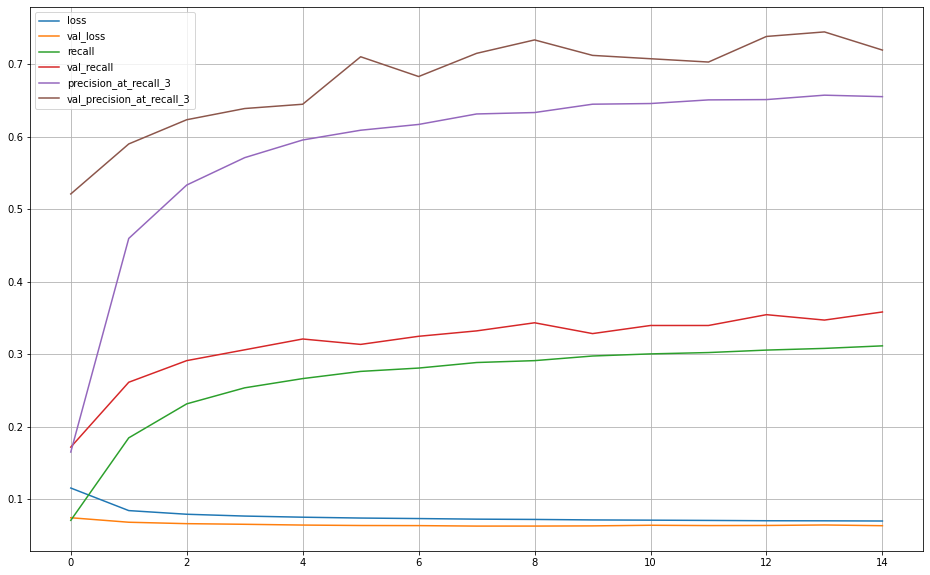

In [37]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'precision_at_recall_3', 'val_precision_at_recall_3' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [10]:
pd.DataFrame(history.history)[['fp', 'val_fp', 'tp', 'val_tp', 'fn', 'val_fn' ]]

,fp,val_fp,tp,val_tp,fn,val_fn
0,"6,706.00",18.00,"6,649.00",50.00,"108,397.00",218.00
1,"9,409.00",26.00,"20,796.00",70.00,"94,250.00",198.00
2,"10,944.00",30.00,"26,957.00",82.00,"88,089.00",186.00
3,"11,467.00",29.00,"30,081.00",83.00,"84,965.00",185.00
4,"11,875.00",29.00,"32,267.00",89.00,"82,779.00",179.00
5,"12,380.00",35.00,"33,775.00",93.00,"81,271.00",175.00
6,"12,401.00",33.00,"34,883.00",101.00,"80,163.00",167.00
7,"12,743.00",29.00,"35,852.00",98.00,"79,194.00",170.00


In [11]:
model.evaluate(X_valid, y_valid)

603/603 [==============================] - 5s 7ms/step - loss: 0.0658 - precision_at_recall: 0.7251 - recall: 0.3382 - auc: 0.9515 - fp: 2779.0000 - fn: 19150.0000 - tp: 9788.0000 - accuracy: 0.9777 - precision: 0.7789


[0.06582780182361603,
 0.7251294255256653,
 0.338240385055542,
 0.9515117406845093,
 2779.0,
 19150.0,
 9788.0,
 0.9777025580406189,
 0.7788652777671814]

In [15]:
print(X_valid.shape)
print(y_valid.shape)

(19284, 2000)
(19284, 51)


In [16]:
X_test = X_body_test.toarray()
y_test = y_tags_test
print(X_test.shape)
print(y_test.shape)

(13836, 2000)
(13836, 51)


In [39]:
model.evaluate(X_test, y_test)

433/433 [==============================] - 7s 15ms/step - loss: 0.0670 - precision_at_recall_3: 0.7261 - recall: 0.3288 - auc: 0.9496 - fp: 1901.0000 - fn: 13974.0000 - tp: 6846.0000 - accuracy: 0.9775 - precision: 0.7827 2s - loss: 0.0673 - precision_at_recall_3: 0.7244 - recall: 0.3286 - auc: 0.9483 - fp: 1258.0000 - fn: 9313.0000 - tp: 4559.0000  - ETA: 0s - loss: 0.0669 - precision_at_recall_3: 0.7248 - recall: 0.3295 - auc: 0.9495 - fp: 1657.0000 - fn: 12132.0000 - tp: 5963.0000 - accuracy: 0.9776 - precision:  - ETA: 0s - loss: 0.0669 - precision_at_recall_3: 0.7238 - recall: 0.3285 - auc: 0.9497 - fp: 1720.0000 - fn: 12545.0000 - tp: 6138.0000 - accuracy: 0.


[0.06696103513240814,
 0.7261213064193726,
 0.3288184404373169,
 0.9495904445648193,
 1901.0,
 13974.0,
 6846.0,
 0.9775023460388184,
 0.7826683521270752]

In [40]:
res = model.predict(X_test)

In [41]:
mlb.inverse_transform(y_test[1000:1010])

[('css', 'html'),
 ('dplyr', 'r'),
 ('other',),
 ('c',),
 ('arrays', 'numpy', 'python'),
 ('java',),
 ('dataframe',),
 ('python',),
 ('r',),
 ('python',)]

In [42]:
threshold = .15
tmp= pd.DataFrame(res[1000:1010]).applymap(lambda x:1 if x>threshold else 0)
mlb.inverse_transform(tmp.values)

[('css', 'html', 'javascript', 'other'),
 ('dplyr', 'r'),
 ('javascript', 'other'),
 ('c', 'c++'),
 ('arrays', 'numpy', 'python'),
 ('java', 'other'),
 ('dataframe', 'pandas', 'python', 'r'),
 ('python',),
 ('c', 'c++', 'r'),
 ('other', 'regex')]

In [49]:
mlb.inverse_transform(y_test[8750:8760])

[('javascript', 'python'),
 ('java',),
 ('other',),
 ('c++',),
 ('java',),
 ('python',),
 ('other',),
 ('bash',),
 ('dataframe', 'list', 'pandas', 'python'),
 ('css', 'html')]

In [51]:
res = model.predict(X_test[8750:8760])
for z in np.arange(res.shape[0]):
    classes = ""
    for r in np.arange(len(mlb.classes_)):
        if res[z][r]>.15:
            classes = classes + mlb.classes_[r] + ", "
    print("classe: ", classes )

classe:  other, python, 
classe:  arrays, javascript, python, 
classe:  python, 
classe:  c++, rust, 
classe:  java, 
classe:  python, 
classe:  javascript, sql, 
classe:  bash, other, python, 
classe:  dataframe, pandas, python, 
classe:  javascript, reactjs, 


In [54]:
df_tags_test[8750:8760]

,Tags_T100,Tags_T50,Tags_T10
8750,"[javascript, python]","[javascript, python]","[javascript, python]"
8751,[java],[java],[java]
8752,[other],[other],[other]
8753,[c++],[c++],[c++]
8754,"[java, database]",[java],[java]
8755,[python],[python],[python]
8756,[vba],[other],[other]
8757,"[bash, loops]",[bash],[other]
8758,"[python, pandas, list, dataframe]","[python, pandas, list, dataframe]","[python, pandas, dataframe]"
8759,"[html, css]","[html, css]",[other]


In [52]:
df_lemma_test.loc[8759,'Title']

'get hang indent dd tag cs also content'

In [53]:
df_lemma_test.loc[8759,'Body']

'page bunch definition list guy make style mockups word come brilliant idea render definition list term value hang indent admit actually brilliant difficult play around quite bit hang indent really necessary page becomes ugly grid suboptimal anyway page render break content appear hang indent style honor actually oppose method say hang indent hang keyword glitchy like render believe else'